# Churn Prediction Exercise

In this exercise, you will build and tune six different classification models on a business dataset (Customer Churn), applying feature engineering, model evaluation, overfitting checks, and hyperparameter tuning.

## Dataset
We will use the Telco Customer Churn dataset from Kaggle, which contains 7,043 customer records and 21 columns, including the target variable Churn (Yes/No).

Notable features include (as detailed in EDA and feature descriptions):
• customerID, gender, SeniorCitizen, Partner, Dependents, tenure
• PhoneService, MultipleLines, InternetService
• OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
• Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn

**Link:** https://www.kaggle.com/datasets/blastchar/telco-customer-churn

## Step 1 – Load & Explore Data

### Load dataset with Pandas

In [104]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [105]:
file_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "blastchar/telco-customer-churn",
    file_path
)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Explore distributions, missing values, and class imbalance.

In [106]:
import sweetviz as sv

In [107]:
report = sv.analyze(df)
report.show_html("sweetviz_eda.html")

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Identify categorical vs. numerical features.

In [108]:
import numpy as np

In [109]:
# numeric and categorical detection
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'Numeric columns ({len(num_cols)}):')
print(num_cols)

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'\nCategorical columns ({len(cat_cols)}) :')
print(cat_cols)

# binary-like columns (two distinct non-null values)
binary_cols = [c for c in df.columns if df[c].nunique(dropna=True) == 2]
print('\nBinary-like columns (nunique==2):')
print(binary_cols)

Numeric columns (3):
['SeniorCitizen', 'tenure', 'MonthlyCharges']

Categorical columns (18) :
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']

Binary-like columns (nunique==2):
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


## Step 2 – Data Preparation

In [110]:
# 1. Handle missing values
# Get rows with missing (including empty/whitespace) values and totals per column
import pandas as pd

# Convert empty/whitespace-only strings in object columns to NA for accurate counting
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    df[obj_cols] = df[obj_cols].apply(lambda s: s.astype(str).str.strip()).replace({'': pd.NA})

# missing mask and totals
missing_mask = df.isnull()
missing_per_col = missing_mask.sum()
missing_per_col_pct = (missing_per_col / len(df) * 100).round(2)
missing_per_row = missing_mask.sum(axis=1)
n_rows_with_missing = int((missing_per_row > 0).sum())

print(f'Rows with any missing (including converted empty/whitespace): {n_rows_with_missing} / {len(df)}')

# Tidy summary per column
missing_summary = (
    pd.DataFrame({'missing_count': missing_per_col, 'missing_pct': missing_per_col_pct})
    .reset_index()
    .rename(columns={'index': 'column'})
    .sort_values('missing_count', ascending=False)
)

# Display only columns with non-zero missing values
nonzero_missing = missing_summary[missing_summary['missing_count'] > 0].copy()
if nonzero_missing.empty:
    print('No missing values detected after converting empty/whitespace to NA.')
else:
    display(nonzero_missing)

if n_rows_with_missing > 0:
    # Dataframe of rows that contain any missing values
    missing_rows_df = df[missing_per_row > 0].copy()
    print('\nSample rows that have missing values:')
    display(missing_rows_df.head())

    # Show rows with most missing values (index + count)
    top_missing = (
        missing_rows_df.assign(_n_missing=missing_rows_df.isnull().sum(axis=1))
        .sort_values('_n_missing', ascending=False)[['_n_missing']]
    )

    # Optionally, inspect which columns are most often missing
    print('\nColumns with missing values (non-zero only):')
    display(nonzero_missing)
else:
    # already handled above; keep for clarity
    pass

Rows with any missing (including converted empty/whitespace): 11 / 7043


,column,missing_count,missing_pct
19,TotalCharges,11,0.16


Rows with any missing (including converted empty/whitespace): 11 / 7043


,column,missing_count,missing_pct
19,TotalCharges,11,0.16



Sample rows that have missing values:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,<NA>,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,<NA>,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,<NA>,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,<NA>,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,<NA>,No


Rows with any missing (including converted empty/whitespace): 11 / 7043


,column,missing_count,missing_pct
19,TotalCharges,11,0.16



Sample rows that have missing values:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,<NA>,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,<NA>,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,<NA>,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,<NA>,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,<NA>,No



Columns with missing values (non-zero only):


Rows with any missing (including converted empty/whitespace): 11 / 7043


,column,missing_count,missing_pct
19,TotalCharges,11,0.16



Sample rows that have missing values:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,<NA>,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,<NA>,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,<NA>,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,<NA>,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,<NA>,No



Columns with missing values (non-zero only):


,column,missing_count,missing_pct
19,TotalCharges,11,0.16


In [111]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [112]:
# 2. Encode categorical features (one-hot encoding) and ensure column dtypes are correct
# Map target
df["Churn"] = df["Churn"].map({'Yes': 1, 'No': 0})

# Clean object columns: strip and convert empty->NA (safe to run multiple times)
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    df[obj_cols] = df[obj_cols].apply(lambda s: s.astype(str).str.strip())
    df[obj_cols] = df[obj_cols].replace({'': pd.NA})

# Coerce known numeric-like columns to numeric (common gotcha: TotalCharges)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Convert boolean columns to int so transformers treat them as numeric
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
for c in bool_cols:
    df[c] = df[c].astype('int64')

# Define X and y after cleaning
X = df.drop(columns=['Churn'])
y = df['Churn']

# Recompute feature lists robustly
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Ensure numeric columns are numeric (coerce any remaining object to numeric where appropriate)
for c in numeric_features:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# Final checks and info
print(f'Numeric features ({len(numeric_features)}):', numeric_features)
print(f'Categorical features ({len(categorical_features)}):', categorical_features)

# Train / test split (80/20), stratify for class imbalance
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Numeric features (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features (16): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Train size: (5634, 20), Test size: (1409, 20)


## Step 3 – Baseline Models

In [113]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
        ]
    )
# Preprocessing for categorical features: impute + one-hot
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ]
)

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:

models = {}

models["Logistic Regression"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            max_iter=1000,
            C=0.01,            
            random_state=RANDOM_STATE))
        ]
)

models["Decision Tree"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", DecisionTreeClassifier(
            max_depth=3,
            random_state=RANDOM_STATE))
    ]
)

models["Random Forest"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=100, random_state=RANDOM_STATE
        ))
    ]
)

models["XGBoost"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            use_label_encoder=False
        ))
    ]
)

models["CatBoost"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", CatBoostClassifier(
            iterations=200,
            learning_rate=0.1,
            depth=5,
            loss_function="Logloss",
            verbose=False,
            random_state=RANDOM_STATE
        ))
    ]
)

models["k-NN"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", KNeighborsClassifier(n_neighbors=5, weights="distance"))
    ]
)


In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

estimators = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    'k-NN': KNeighborsClassifier()
}
param_grids = {
    'LogisticRegression': {'model__C': [0.01, 0.1, 1, 10, 100]},
    'DecisionTree': {'model__max_depth': [3, 5, 10, None]},
    'RandomForest': {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None]},
    'XGBoost': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 7], 'model__learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'model__iterations': [100, 200], 'model__depth': [3, 5, 7], 'model__learning_rate': [0.01, 0.1, 0.2]},
    'k-NN': {'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance']}
}
# Ensure X_train/X_test are DataFrames and y numeric
X_train = pd.DataFrame(X_train).reset_index(drop=True).copy()
X_test = pd.DataFrame(X_test).reset_index(drop=True).copy()
y_train = pd.Series(y_train).astype(int).reset_index(drop=True)
y_test = pd.Series(y_test).astype(int).reset_index(drop=True)

results = []
for name, est in estimators.items():
    pipe = Pipeline([('pre', preprocessor), ('model', est)])
    param_grid = param_grids[name]
    gs = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    results.append({'name': name, 'best_params': gs.best_params_, 'cv_score': gs.best_score_, 'test_r2': test_r2, 'test_rmse': test_rmse})
    print(f"{name} - best_params: {gs.best_params_} - CV (neg MSE): {gs.best_score_:.4f} - Test R2: {test_r2:.4f} - Test RMSE: {test_rmse:.4f}")


LogisticRegression - best_params: {'model__C': 0.01} - CV (neg MSE): -0.1956 - Test R2: -0.0338 - Test RMSE: 0.4490
DecisionTree - best_params: {'model__max_depth': 3} - CV (neg MSE): -0.2121 - Test R2: -0.1175 - Test RMSE: 0.4668
RandomForest - best_params: {'model__max_depth': None, 'model__n_estimators': 100} - CV (neg MSE): -0.2045 - Test R2: -0.0665 - Test RMSE: 0.4560


d:\workspace\classical-machine-learning\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [20:23:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - best_params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100} - CV (neg MSE): -0.1970 - Test R2: 0.0208 - Test RMSE: 0.4369
CatBoost - best_params: {'model__depth': 5, 'model__iterations': 200, 'model__learning_rate': 0.1} - CV (neg MSE): -0.1922 - Test R2: 0.0026 - Test RMSE: 0.4410
k-NN - best_params: {'model__n_neighbors': 9, 'model__weights': 'uniform'} - CV (neg MSE): -0.2219 - Test R2: -0.1284 - Test RMSE: 0.4691



LOGISTIC REGRESSION
------------------------------------------------------------


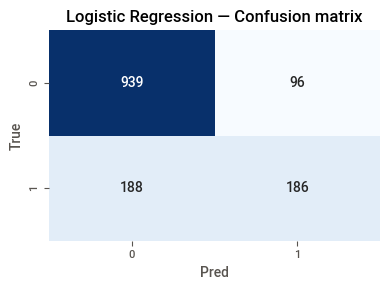


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



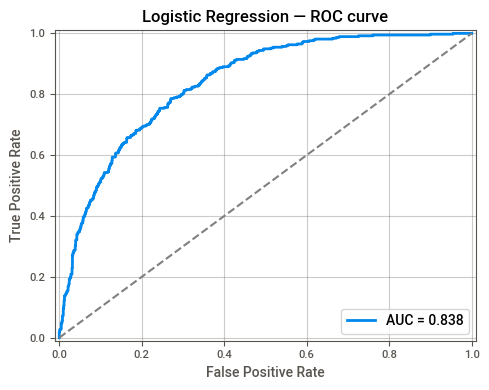


DECISION TREE
------------------------------------------------------------


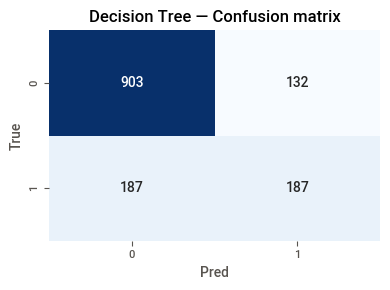


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.69      1409
weighted avg       0.76      0.77      0.77      1409



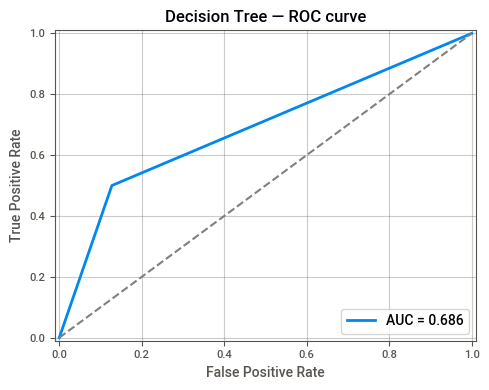


RANDOM FOREST
------------------------------------------------------------


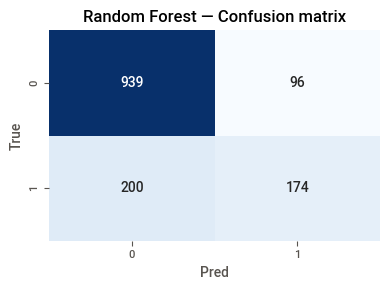


Classification report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



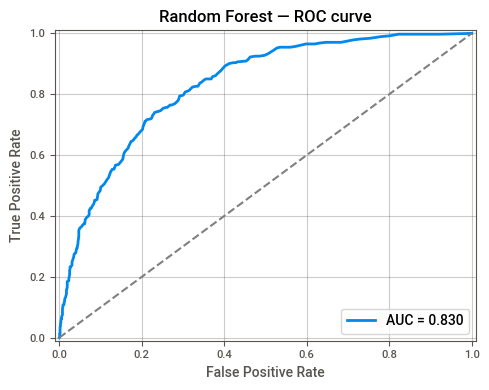


XGBOOST
------------------------------------------------------------


d:\workspace\classical-machine-learning\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [21:14:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


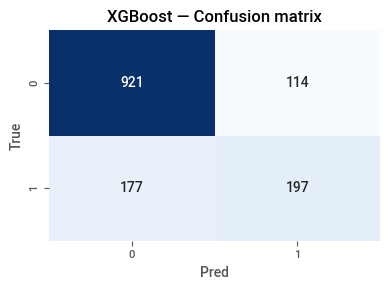


Classification report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



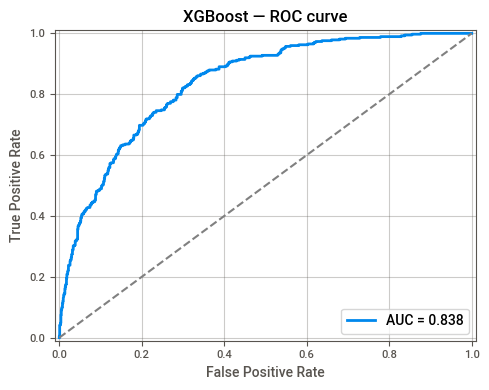


CATBOOST
------------------------------------------------------------


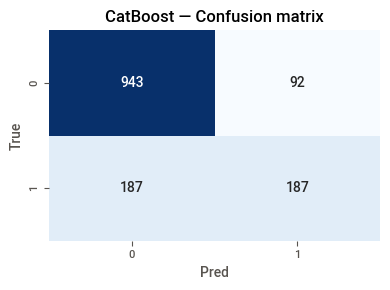


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.67      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



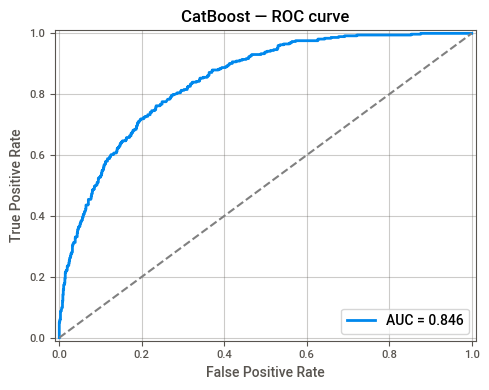


K-NN
------------------------------------------------------------


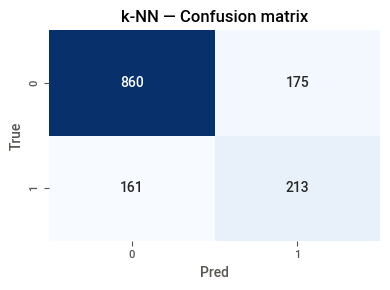


Classification report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1035
           1       0.55      0.57      0.56       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.76      0.76      0.76      1409



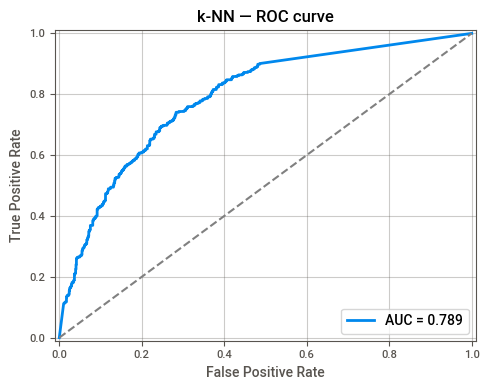


SUMMARY TABLE (sorted by F1 then AUC):


,model,accuracy,precision,recall,f1,auc
0,XGBoost,0.793471,0.633441,0.526738,0.575182,0.837748
1,CatBoost,0.801987,0.670251,0.500000,0.572741,0.845714
2,Logistic Regression,0.798439,0.659574,0.497326,0.567073,0.838058
3,k-NN,0.761533,0.548969,0.569519,0.559055,0.789120
4,Random Forest,0.789922,0.644444,0.465241,0.540373,0.830071
5,Decision Tree,0.773598,0.586207,0.500000,0.539683,0.686232


In [126]:
# PER-MODEL: fit, metrics, confusion matrix and ROC (model name separator in UPPERCASE)
import traceback
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc, classification_report)

# Ensure data types
X_train = pd.DataFrame(X_train).reset_index(drop=True).copy()
X_test = pd.DataFrame(X_test).reset_index(drop=True).copy()
y_train = pd.Series(y_train).astype(int).reset_index(drop=True)
y_test = pd.Series(y_test).astype(int).reset_index(drop=True)

# Quick preprocessor check
try:
    _ = preprocessor.fit_transform(X_train)
    preproc_ok = True
except Exception:
    preproc_ok = False
    print('Preprocessor failed — inspect numeric/categorical feature lists or column types:')
    traceback.print_exc()

if not preproc_ok:
    raise RuntimeError('Preprocessing failed. Fix feature lists or types before training models.')

results = []

for name, pipe in models.items():
    print('\n' + ('=' * 60))
    print(name.upper())
    print('-' * 60)

    # Fit model
    try:
        pipe.fit(X_train, y_train)
    except Exception:
        print('FIT ERROR:')
        traceback.print_exc()
        # record error and continue
        results.append({'model': name, 'error': 'fit error'})
        continue

    # Predict
    try:
        y_pred = pipe.predict(X_test)
    except Exception:
        print('PREDICT ERROR:')
        traceback.print_exc()
        results.append({'model': name, 'error': 'predict error'})
        continue

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Confusion matrix display
    try:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues')
        plt.title(f'{name} — Confusion matrix')
        plt.xlabel('Pred')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    except Exception:
        print('Unable to plot confusion matrix')

    # Print classification report succinctly
    try:
        print('\nClassification report:')
        print(classification_report(y_test, y_pred, zero_division=0))
    except Exception:
        pass

    # ROC & AUC (prefer predict_proba, fallback to decision_function)
    auc_val = None
    y_score = None
    try:
        y_score = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_score = pipe.decision_function(X_test)
        except Exception:
            y_score = None

    if y_score is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            auc_val = auc(fpr, tpr)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, lw=2, label=f'AUC = {auc_val:.3f}')
            plt.plot([0,1], [0,1], linestyle='--', color='gray')
            plt.xlim([-0.01,1.01])
            plt.ylim([-0.01,1.01])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{name} — ROC curve')
            plt.legend(loc='lower right')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        except Exception:
            print('Unable to compute/plot ROC for', name)
    else:
        print('No continuous scores available for ROC for', name)

    # store results
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc_val
    })

# Summary table
res_df = pd.DataFrame([r for r in results if 'model' in r])
if not res_df.empty:
    res_df = res_df.sort_values(['f1', 'auc'], ascending=[False, False]).reset_index(drop=True)
    print('\nSUMMARY TABLE (sorted by F1 then AUC):')
    display(res_df)
else:
    print('\nNo successful model runs to summarize (see above errors).')